In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_selection import mutual_info_classif
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
import re
from sklearn import metrics
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score

In [3]:
road_condition = pd.read_csv("/content/drive/My Drive/a2-datasets/road_surface_cond.csv")
atmospheric_condition = pd.read_csv("/content/drive/My Drive/a2-datasets/atmospheric_cond.csv")
node = pd.read_csv("/content/drive/My Drive/a2-datasets/node.csv")[['ACCIDENT_NO', 'NODE_TYPE']]
person = pd.read_csv("/content/drive/My Drive/a2-datasets/person.csv")
accident = pd.read_csv("/content/drive/My Drive/a2-datasets/accident.csv")
filtered_vehicle = pd.read_csv("/content/drive/My Drive/a2-datasets/filtered_vehicle.csv")

In [4]:
#MAPPING
seatbelt_map = {
    1: "Seatbelt Worn",
    2: "Seatbelt Not Worn"}

injury_map = {
    1: "Fatality",
    2: "Serious injury",
    3: "Other injury",
    4: "Not injured"}

severity_map = {
    1: 'Fatal',
    2: 'Serious',
    3: 'Injury',
    4: 'Non-injury'}

road_condition_map = {
    1: 'Dry',
    2: 'Wet',
    3: 'Muddy',
    4: 'Snowy',
    5: 'Icy',
    9: 'Unknown'}

atmospheric_condition_map = {
    1: 'Clear',
    2: 'Raining',
    3: 'Snowing',
    4: 'Fog',
    5: 'Smoke',
    6: 'Dust',
    7: 'Strong Winds',
    9: 'Not Known'}

node_map = {
    'I': "Intersection",
    'N': "Non-Intersection",
    'O': "Off-Road",
    " ": "Unknown"}

fuel_type_labels = {
    'P': 'Petrol',
    'M': 'Methanol',
    'D': 'Diesel',
    'G': 'Gas',
    'Z': 'Other',
    'E': 'Electric',
    'S': 'Solar',
    'O': 'Other/Unknown'
}

vehicle_type_map = {
    1: 'Car',
    2: 'Station Wagon',
    3: 'Taxi',
    4: 'Utility',
    5: 'Panel Van',
    6: 'Prime Mover >1 Trailers',
    7: 'Rigid Truck',
    8: 'Bus/Coach',
    9: 'Minibus',
    10: 'Motorcycle',
    11: 'Moped',
    12: 'Motor Scooter',
    17: 'Other Vehicles',
    19: 'Parked Trailers',
    27: 'Agricultural Equipment',
    60: 'Prime Mover',
    61: 'Prime Mover Single Trailer',
    62: 'Prime Mover B-Double',
    63: 'Prime Mover B-Triple',
    71: 'Light Commercial Vehicle',
    72: 'Heavy Vehicle (Rigid) > 4.5T',
}

PREPROCESSING

In [5]:
#CATEGORISING AGE_GROUP
#helper function to categorise values in 'AGE_GROUP' into broader ranges
def categorise_age_group(age_group):
    #extract numbers from age_group string using regex
    match = re.findall(r'\d+', str(age_group))
    if not match:
        #return original value if no viable value found
        return age_group
    #convert lower bound of age range to an integer
    lower = int(match[0])
    #implement set of conditional statements to assign specific age group based on lower bound
    if lower < 16:
        return 'Under 16'
    elif 16 <= lower <= 25:
        return '16-25'
    elif 26 <= lower <= 39:
        return '26-39'
    elif 40 <= lower <= 64:
        return '40-64'
    else:
        return '65+'
#apply helper function 'categorise_age_group' to 'AGE_GROUP' column
person['AGE_GROUP'] = person['AGE_GROUP'].apply(categorise_age_group)

#IMPUTATION
def impute_mode(df, column, unknown_value):

    # Find the proportion of missing values in a given data column
    proportion_missing_values = df[column][df[column] == unknown_value].count()/len(df) # include in report
    print(column, proportion_missing_values)

    # Calculate the mode in the given data column and replace the entries with missing values with the mode
    mode_value = df[df[column] != unknown_value][column].mode()[0]
    df[column] = df[column].replace(unknown_value, mode_value)

#DATA VISUALISATION FUNCTIONS
#proportionof categories bar graphs
def proportion_by_category(df, desc_col, factor, labels_dict):

    counts = df[desc_col].value_counts().sort_index()
    proportions = counts / counts.sum()
    #label
    x_labels = [labels_dict.get(code, str(code)) for code in counts.index]
    plt.figure(figsize=(10, 6))
    plt.bar(x_labels, proportions)
    plt.title(f"Proportions of the Various {factor} for all Accidents")
    plt.xlabel(f"{factor}")
    plt.ylabel("Proportion of Accidents")
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

injury_order = ["Fatality", "Serious injury", "Other injury", "Not injured"]
seatbelt_order = ["Seatbelt Worn", "Seatbelt Not Worn"]
age_order = ['Under 16', '16-25', '26-39', '40-64', '65+']


#HEATMAP
def plot_heatmap(df, yaxis, xaxis, title, row_order=None, col_order=None, figsize = (10,6)):
    heatmap_data = df.groupby([yaxis, xaxis]).size().reset_index(name='Count')

    # Obtain proportions of each accident severity level given one category of one of the predetermined features
    sums = df.groupby(xaxis)["ACCIDENT_NO"].count()
    proportions = list()
    for i in range(len(heatmap_data['Count'])):
        proportions.append(round(heatmap_data['Count'].iloc[i]/sums[heatmap_data[xaxis].iloc[i]],3))
    heatmap_data['Proportions'] = pd.Series(proportions)

    # PIVOT TABLE
    pivot_data = heatmap_data.pivot_table(index=yaxis, columns=xaxis, values='Proportions', fill_value=0)

    if row_order:
        pivot_data = pivot_data.reindex(index=row_order, fill_value=0)
    if col_order:
        pivot_data = pivot_data.reindex(columns=col_order, fill_value=0)

    # PLOT HEATMAP
    plt.figure(figsize=figsize)
    sns.heatmap(pivot_data, annot=True, fmt='g')
    plt.title(title)
    plt.ylabel(yaxis.replace('_', ' '))
    plt.xlabel(xaxis.replace('_', ' '))
    plt.tight_layout()
    plt.show()

FUEL_TYPE_DESC
Petrol      11127
Diesel       2650
Methanol      525
Gas           205
Other          23
Electric       13
Name: count, dtype: int64


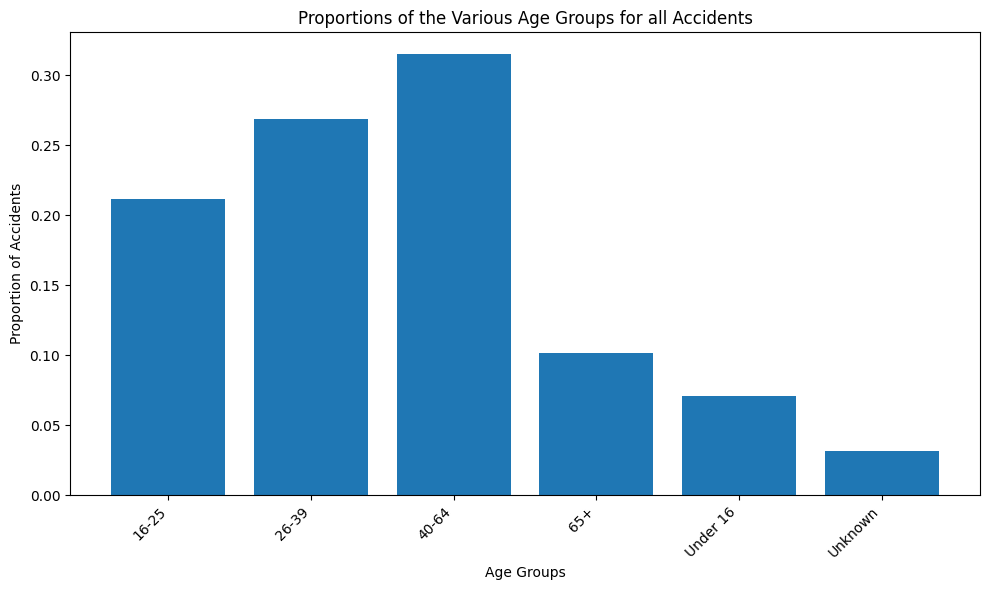

AGE_GROUP 0.03167973754248626


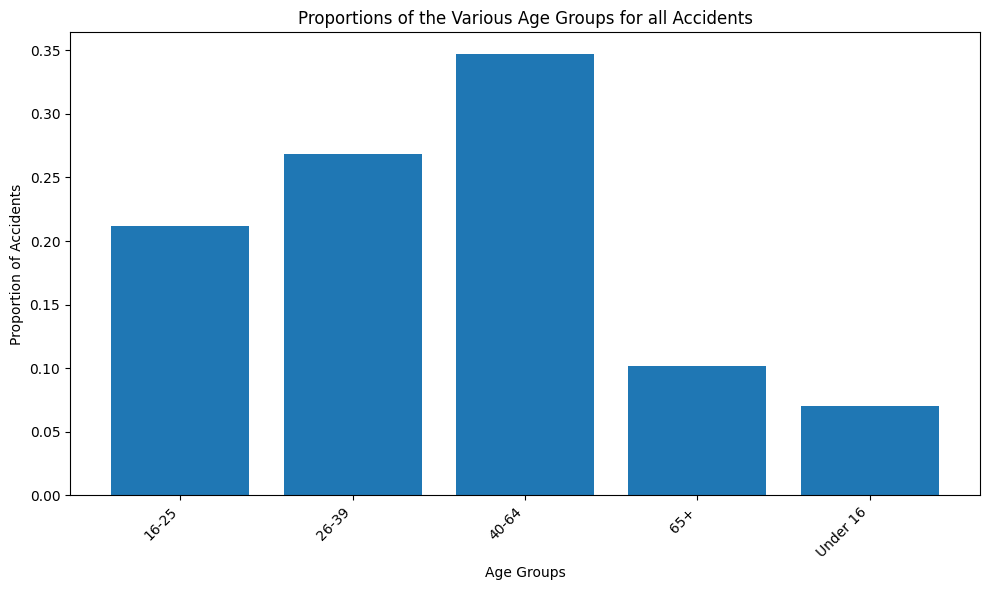

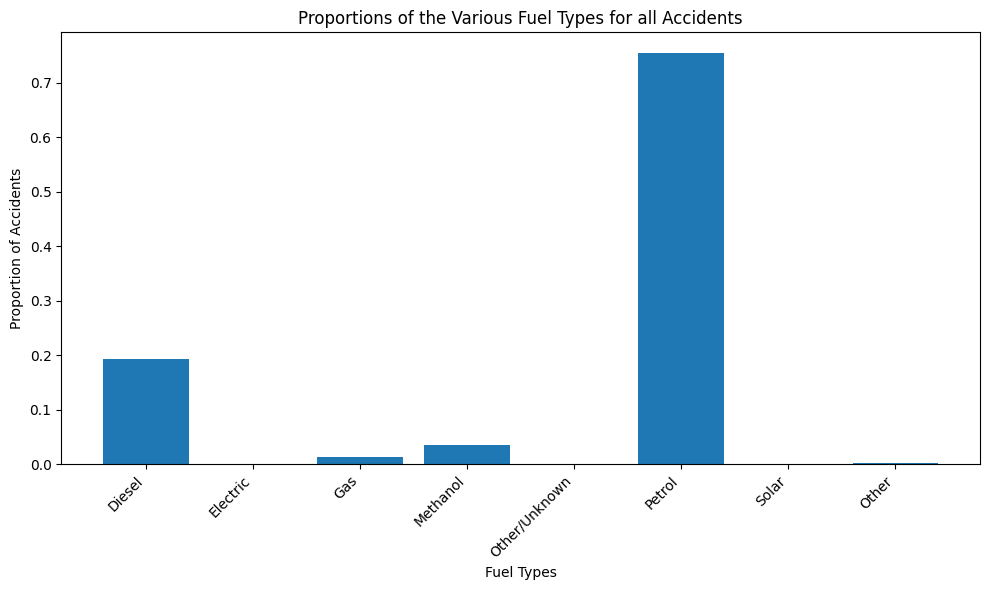

FUEL_TYPE 0.0023202482125994875
FUEL_TYPE 0.00012333545316143454


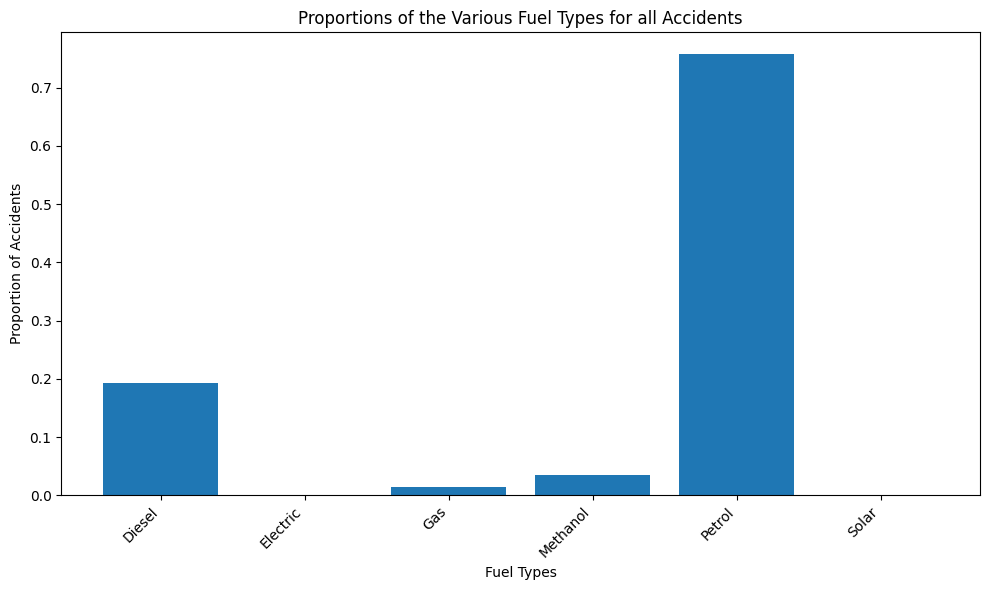

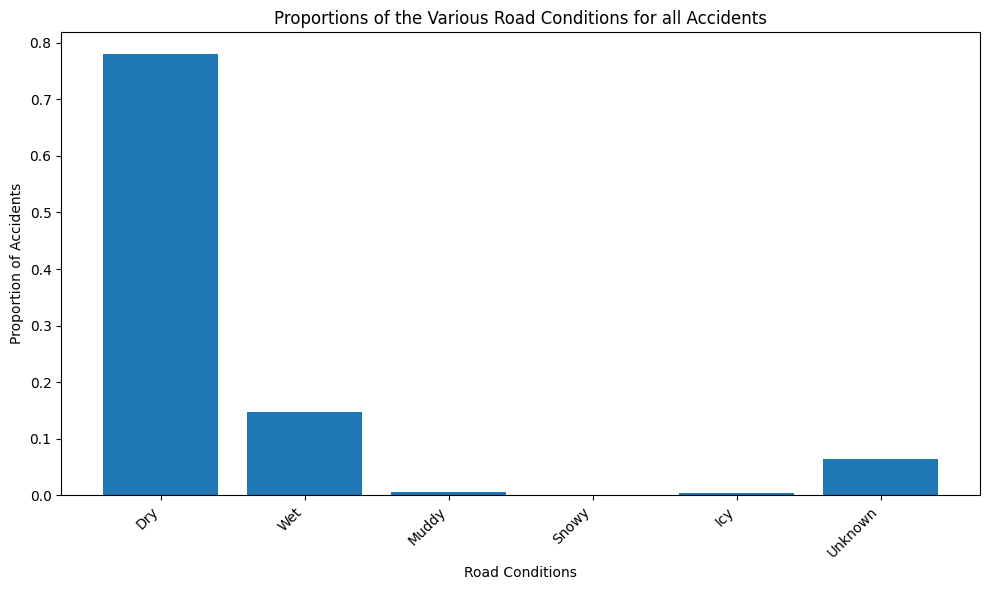

SURFACE_COND 0.06353330184222956


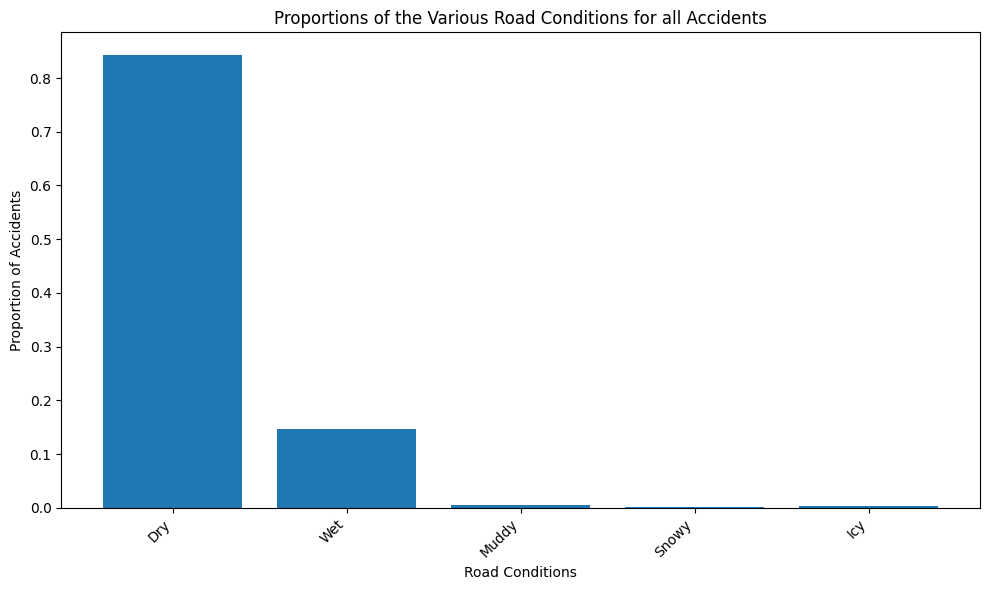

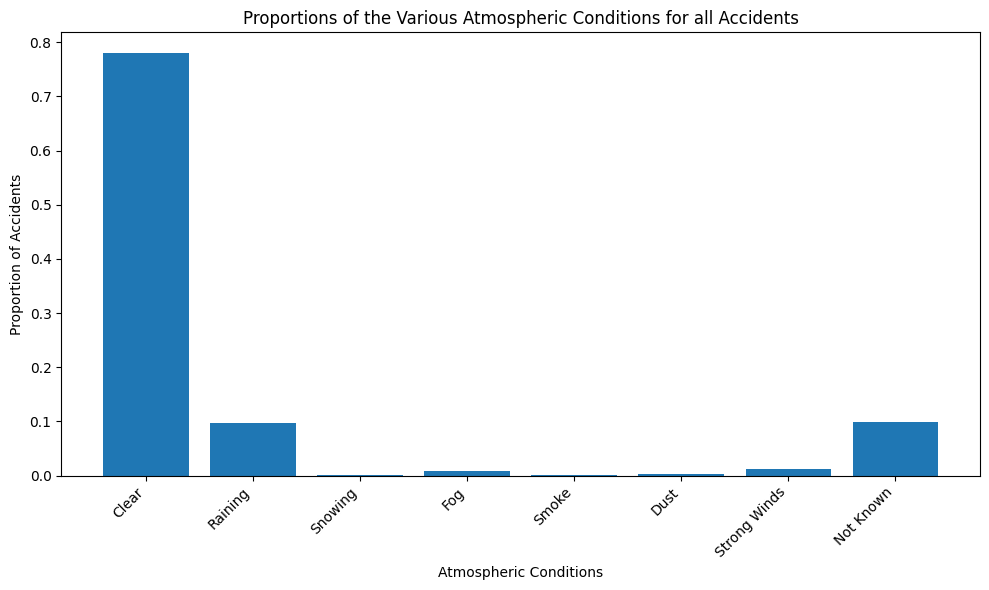

ATMOSPH_COND 0.09968103377770508


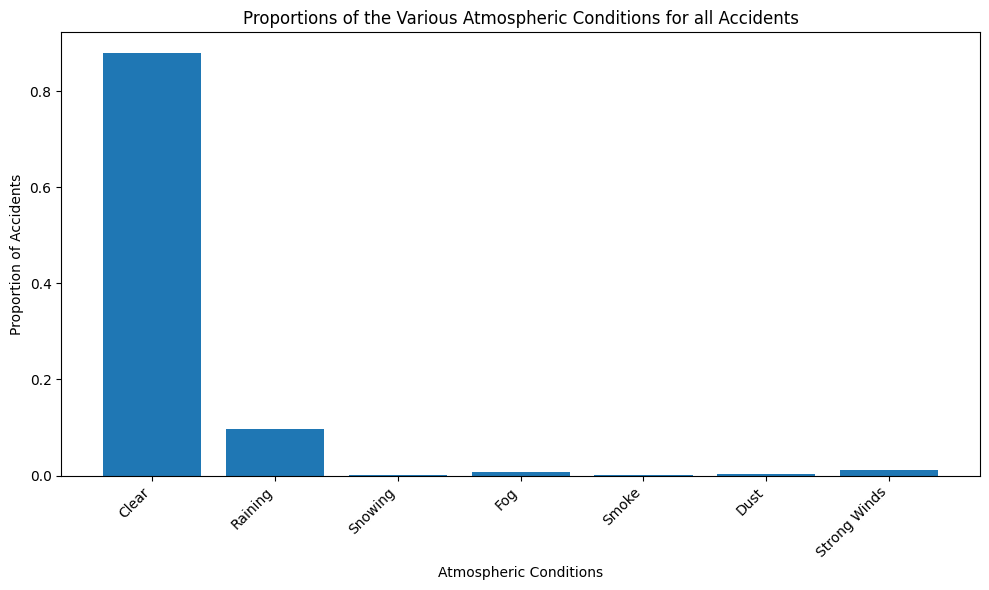

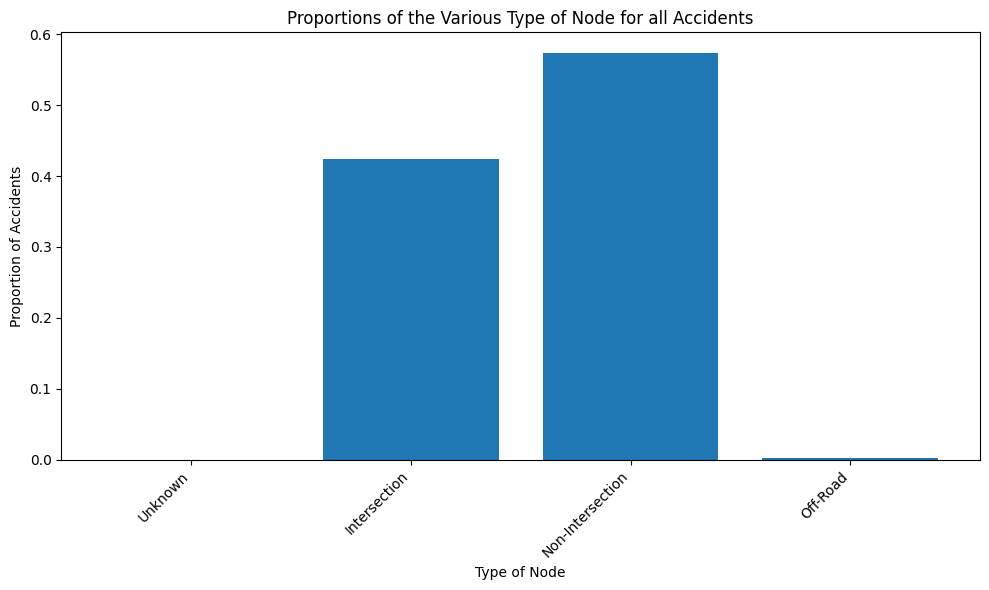

NODE_TYPE 2.71990425937007e-05


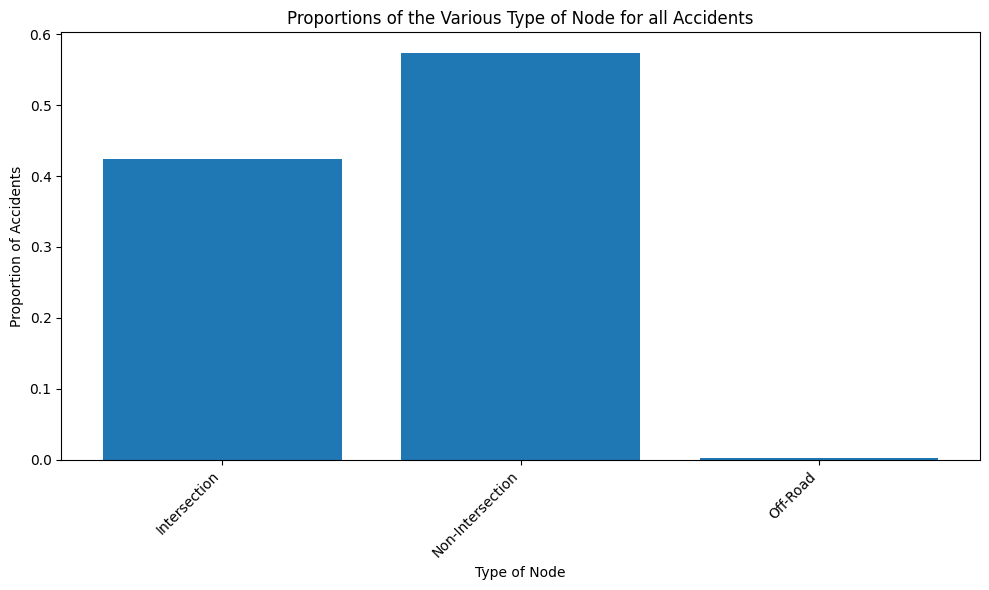

HELMET_BELT_WORN 0.2707964016091595


In [6]:
#HANDLING MISSING VALUES

node['NODE_TYPE_DESC'] = node['NODE_TYPE'].map(node_map)
filtered_vehicle['FUEL_TYPE_DESC'] = filtered_vehicle['FUEL_TYPE'].map(fuel_type_labels)

# Subset the road surface data for only unknown values
subset_road_data = road_condition.loc[road_condition['SURFACE_COND_DESC']=='Unk.']

# Subset the atmospheric condition data for those accidents which were missing in road surface data
subset = atmospheric_condition['ACCIDENT_NO'].isin(subset_road_data['ACCIDENT_NO'])
subset_atmosph_data = atmospheric_condition[subset]

# Subset the person dataset for those accidents which were missing in road surface data
subset = person['ACCIDENT_NO'].isin(subset_road_data['ACCIDENT_NO'])
subset_person_data = person[subset]

# Subset the node type data for those accidents which were missing in road surface data
subset = node['ACCIDENT_NO'].isin(subset_road_data['ACCIDENT_NO'])
subset_node_data = node[subset]

subset = filtered_vehicle['ACCIDENT_NO'].isin(subset_road_data['ACCIDENT_NO'])
subset_vehicle_data = filtered_vehicle[subset]

# Create a plot (2x2) for 4 separate pie charts, with appropriate spacing
fig, ax = plt.subplots(2, 2, figsize = (10,8))
# These pie charts will represent the probability of missing data in features given road surface data is missing
fig.suptitle("Proportion of Categories Given Road Condition Data is Missing", fontsize = "xx-large")

# Find the count of each category in the atmospheric data for which road surface data was missing
category_counts = subset_atmosph_data['ATMOSPH_COND_DESC'].value_counts()
# Group the minority categories together into an "Other" category
category_counts["Other"] = category_counts.loc[(category_counts.index != 'Clear') & (category_counts.index != 'Not known')].sum()
category_counts = category_counts[['Not known', 'Other', 'Clear']] # the categories to represent in the first pie chart
# Pie chart with the category names as the labels and the category counts for the filtered set of categories
ax[0][0].pie(category_counts, labels=category_counts.index, autopct='%1.1f%%', counterclock = False)
ax[0][0].set_title("Proportion of Atmospheric Conditions")

category_counts = subset_vehicle_data['FUEL_TYPE_DESC'].value_counts()
print(category_counts)
category_counts["Minorities"] = category_counts.loc[(category_counts.index != 'Petrol') & (category_counts.index != 'Diesel') & (category_counts.index != 'Other')].sum()
category_counts = category_counts[['Petrol', 'Diesel', 'Other', 'Minorities']] # the categories to represent in the first pie chart
ax[0][1].pie(category_counts, labels=category_counts.index, autopct='%1.1f%%', counterclock = False)
ax[0][1].set_title("Proportion of Fuel Types")

# Find the count of each category in the age group data for which road surface data was missing
category_counts = subset_person_data['AGE_GROUP'].value_counts()
# Pie chart with the age group as the labels and the counts for all categories
ax[1][0].pie(category_counts, labels=category_counts.index, autopct='%1.1f%%', counterclock = False)
ax[1][0].set_title("Proportion of Age Groups")

# Find the count of each category in the node type data for which road surface data was missing
category_counts = subset_node_data['NODE_TYPE_DESC'].value_counts()
# Pie chart with the node type names as the labels and the counts for all categories
ax[1][1].pie(category_counts, labels=category_counts.index, autopct='%1.1f%%', counterclock = False)
ax[1][1].set_title("Proportion of Node Types")

plt.savefig("MCAR")
plt.close()

#DATA VISUALISATION - BAR CHARTS OF PREPROCESSED DATA
# Plot a bar chart representing the proportion of accidents for each age group
proportion_by_category(person, 'AGE_GROUP', 'Age Groups', {})
impute_mode(person, 'AGE_GROUP', 'Unknown') # Impute missing values for age group
proportion_by_category(person, 'AGE_GROUP', 'Age Groups', {})

# Plot a bar chart representing the proportion of accidents for each fuel type
proportion_by_category(filtered_vehicle, 'FUEL_TYPE', 'Fuel Types', fuel_type_labels)
impute_mode(filtered_vehicle, 'FUEL_TYPE', 'Z') # Impute missing values for fuel types
impute_mode(filtered_vehicle, 'FUEL_TYPE', 'O') # Impute missing values for fuel types
proportion_by_category(filtered_vehicle, 'FUEL_TYPE', 'Fuel Types', fuel_type_labels)

# Plot a bar chart representing the proportion of accidents for each road surface condition
proportion_by_category(road_condition, "SURFACE_COND", "Road Conditions", road_condition_map)
impute_mode(road_condition, "SURFACE_COND", 9) # Impute missing values (encoded as 9) with the mode
# Plot the same bar chart again, to see the change in distribution as a result of imputation
proportion_by_category(road_condition, "SURFACE_COND", "Road Conditions", road_condition_map)

# Plot a bar chart representing the proportion of accidents for each atmospheric condition
proportion_by_category(atmospheric_condition, "ATMOSPH_COND", "Atmospheric Conditions", atmospheric_condition_map)
impute_mode(atmospheric_condition, "ATMOSPH_COND", 9) # Impute missing values (again encoded as 9) with mode
# Plot the same bar chart again, to see the change in distribution as a result of imputation
proportion_by_category(atmospheric_condition, "ATMOSPH_COND", "Atmospheric Conditions", atmospheric_condition_map)

# Plot a bar chart representing the proportion of accidents for each node type
proportion_by_category(node, "NODE_TYPE", "Type of Node", node_map)
impute_mode(node, "NODE_TYPE", " ") # Impute missing values with mode
# Plot the same bar chart again, to see the change in distribution as a result of imputation
proportion_by_category(node, "NODE_TYPE", "Type of Node", node_map)

proportion_missing_values = person['HELMET_BELT_WORN'][person['HELMET_BELT_WORN'] == 9].count()/len(person) # include in report
print('HELMET_BELT_WORN', proportion_missing_values)

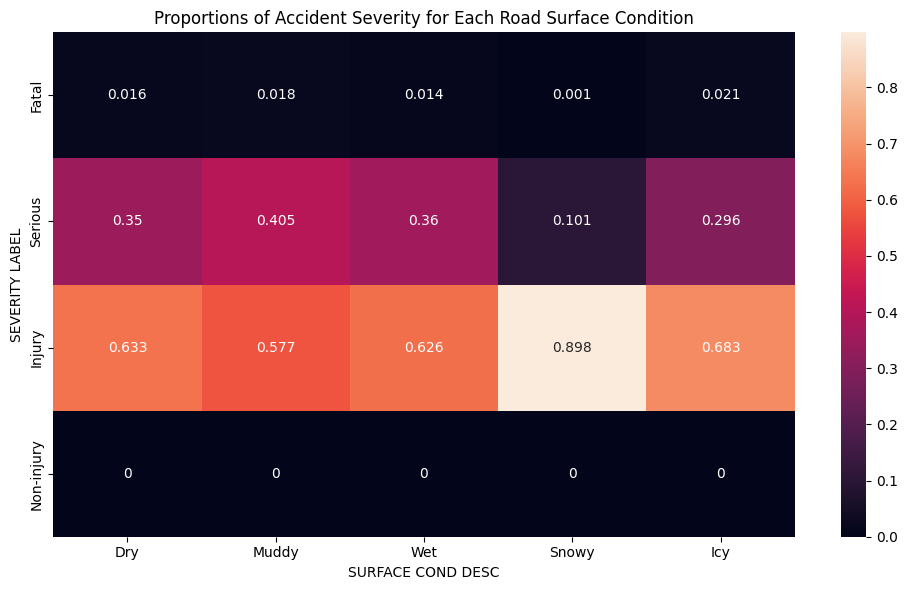

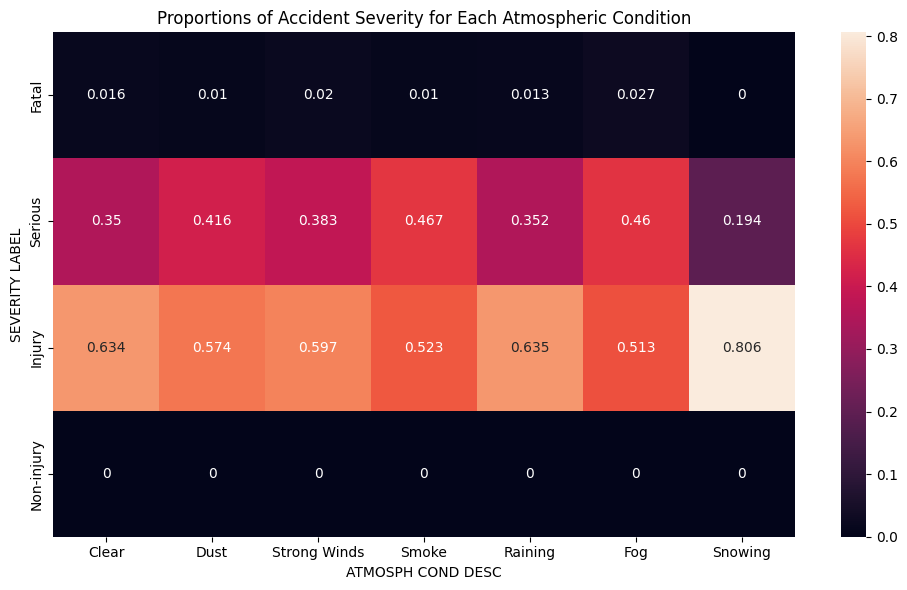

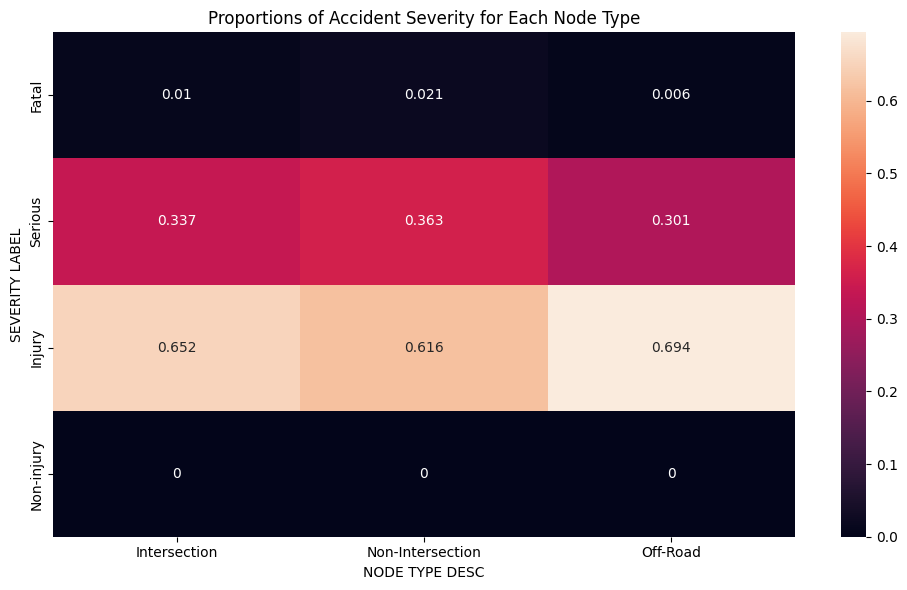

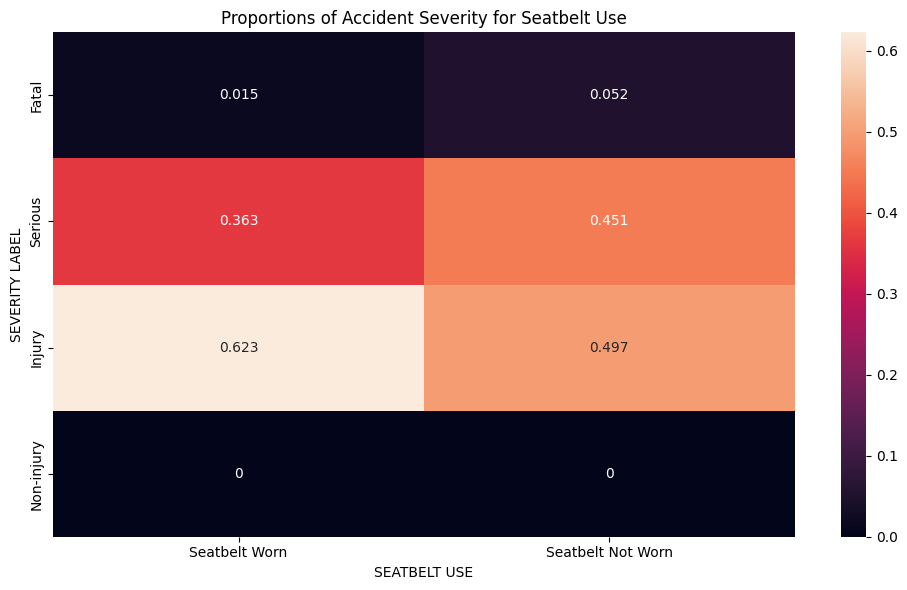

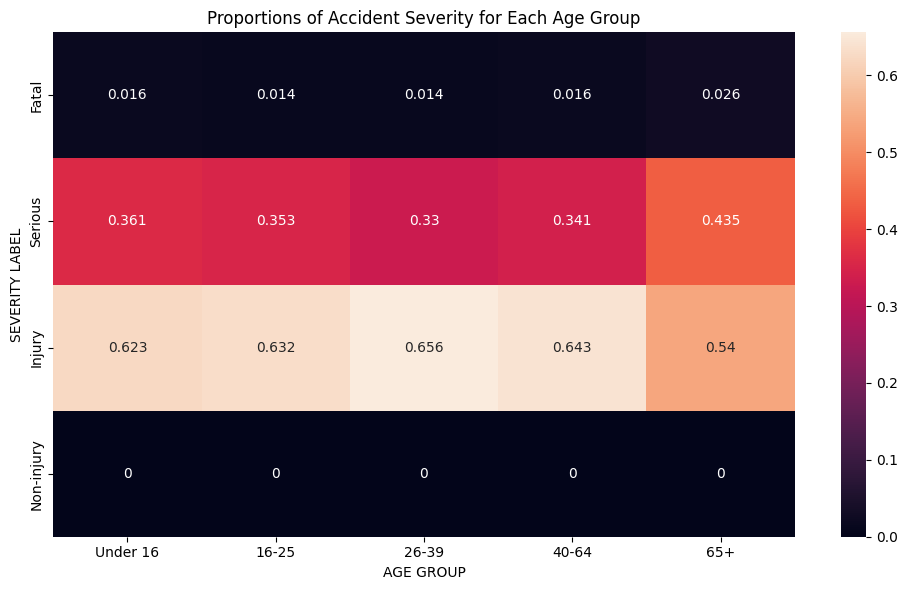

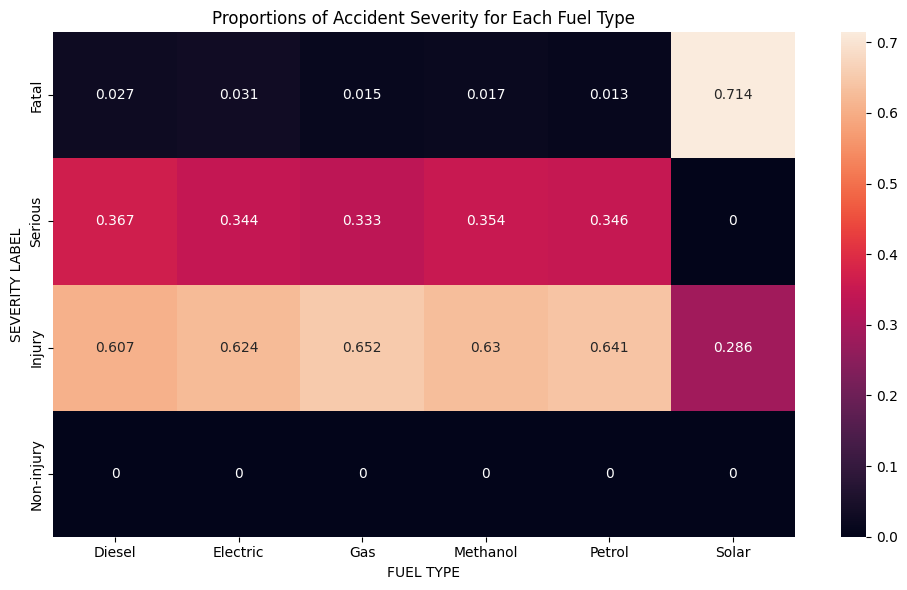

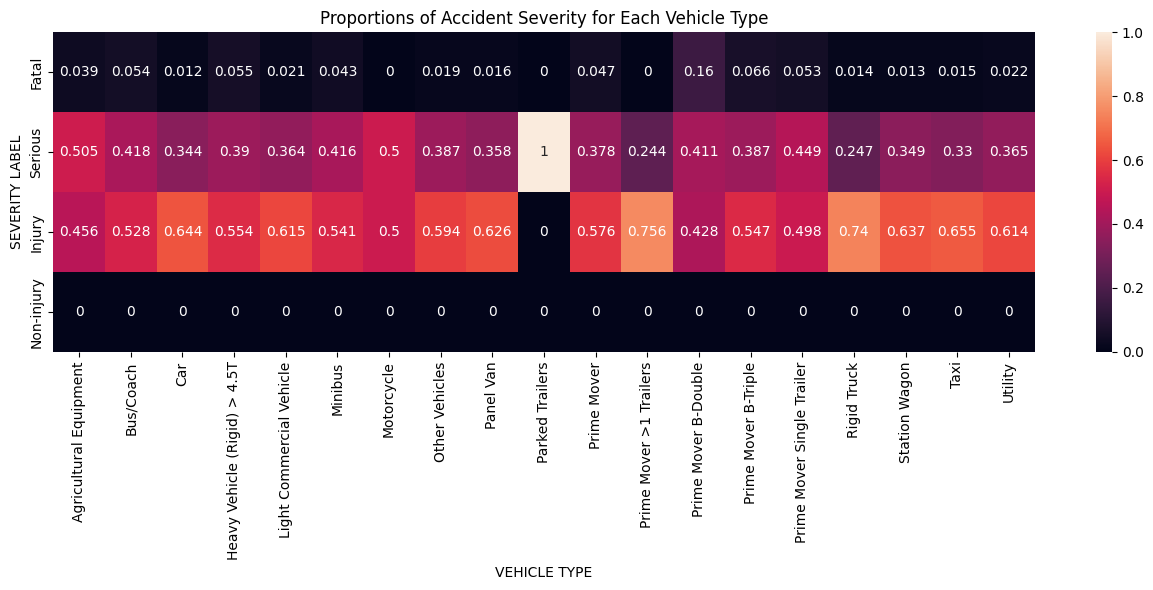

In [7]:
#DATA VISUALISATION - PROPORTION HEATMAPS
# Map the encoded values with appropriate descriptive labels, according to mapping defined above
node['NODE_TYPE_DESC'] = node['NODE_TYPE'].map(node_map)
road_condition['SURFACE_COND_DESC'] = road_condition['SURFACE_COND'].map(road_condition_map)
atmospheric_condition['ATMOSPH_COND_DESC'] = atmospheric_condition['ATMOSPH_COND'].map(atmospheric_condition_map)
person['SEATBELT_USE'] = person['HELMET_BELT_WORN'].map(seatbelt_map)
filtered_vehicle['FUEL_TYPE'] = filtered_vehicle['FUEL_TYPE'].map(fuel_type_labels)
filtered_vehicle['VEHICLE_TYPE'] = filtered_vehicle['VEHICLE_TYPE'].map(vehicle_type_map)
accident['SEVERITY_LABEL'] = accident['SEVERITY'].map(severity_map)

# Merging datasets on unique accident no. as part of preprocessing to get columns of interest and dependent variable in one data object
df = road_condition[["ACCIDENT_NO", "SURFACE_COND", "SURFACE_COND_DESC"]]
for dataframe in [atmospheric_condition[["ACCIDENT_NO", "ATMOSPH_COND", "ATMOSPH_COND_DESC"]], node[["ACCIDENT_NO", "NODE_TYPE", "NODE_TYPE_DESC"]],
                  person[["ACCIDENT_NO", "SEATBELT_USE", "AGE_GROUP"]], filtered_vehicle[["ACCIDENT_NO", "VEHICLE_BODY_STYLE", "FUEL_TYPE", "VEHICLE_TYPE"]],
                  accident[['ACCIDENT_NO','SEVERITY', 'SEVERITY_LABEL']]]:
  df = df.join(dataframe.set_index('ACCIDENT_NO'), on = 'ACCIDENT_NO')

# Plot heatmaps of each subfeature against severity (proportions per subfeature rather than counts) - see plot_heatmap function
plot_heatmap(df, yaxis = "SEVERITY_LABEL", xaxis = "SURFACE_COND_DESC",
             title = "Proportions of Accident Severity for Each Road Surface Condition", # title
             row_order=['Fatal', 'Serious', 'Injury', 'Non-injury'], # Order of accident severity to be displayed on heatmap
             col_order = ['Dry', 'Muddy', 'Wet', 'Snowy', 'Icy']) # Order of road surface conditions to be displayed on heatmap
# Heatmap for the various atmospheric conditions
plot_heatmap(df, yaxis = "SEVERITY_LABEL", xaxis = "ATMOSPH_COND_DESC",
             title = "Proportions of Accident Severity for Each Atmospheric Condition",
             row_order=['Fatal', 'Serious', 'Injury', 'Non-injury'],
             col_order = ['Clear', 'Dust', 'Strong Winds', 'Smoke', 'Raining', 'Fog', 'Snowing']) # Order of atmospheric conditions to be displayed on heatmap
# Heatmap for the various node types
plot_heatmap(df, yaxis = "SEVERITY_LABEL", xaxis = "NODE_TYPE_DESC",
             title = "Proportions of Accident Severity for Each Node Type",
             row_order=['Fatal', 'Serious', 'Injury', 'Non-injury'])
# Heatmap for the various seatbelt usage
plot_heatmap(df, yaxis = "SEVERITY_LABEL", xaxis = "SEATBELT_USE",
             title = "Proportions of Accident Severity for Seatbelt Use",
             row_order=['Fatal', 'Serious', 'Injury', 'Non-injury'],
             col_order = ['Seatbelt Worn', 'Seatbelt Not Worn'])
# Heatmap for the various age groups
plot_heatmap(df, yaxis = "SEVERITY_LABEL", xaxis = "AGE_GROUP",
             title = "Proportions of Accident Severity for Each Age Group",
             row_order=['Fatal', 'Serious', 'Injury', 'Non-injury'],
             col_order = ['Under 16', '16-25', '26-39', '40-64', '65+']) # Order of age group to be displayed
# Heatmap for the various fuel types
plot_heatmap(df, yaxis = "SEVERITY_LABEL", xaxis = "FUEL_TYPE",
             title = "Proportions of Accident Severity for Each Fuel Type",
             row_order=['Fatal', 'Serious', 'Injury', 'Non-injury'])
# Heatmap for the various vehicle types
plot_heatmap(df, yaxis = "SEVERITY_LABEL", xaxis = "VEHICLE_TYPE",
             title = "Proportions of Accident Severity for Each Vehicle Type",
             row_order=['Fatal', 'Serious', 'Injury', 'Non-injury'],
             figsize = (13,6))

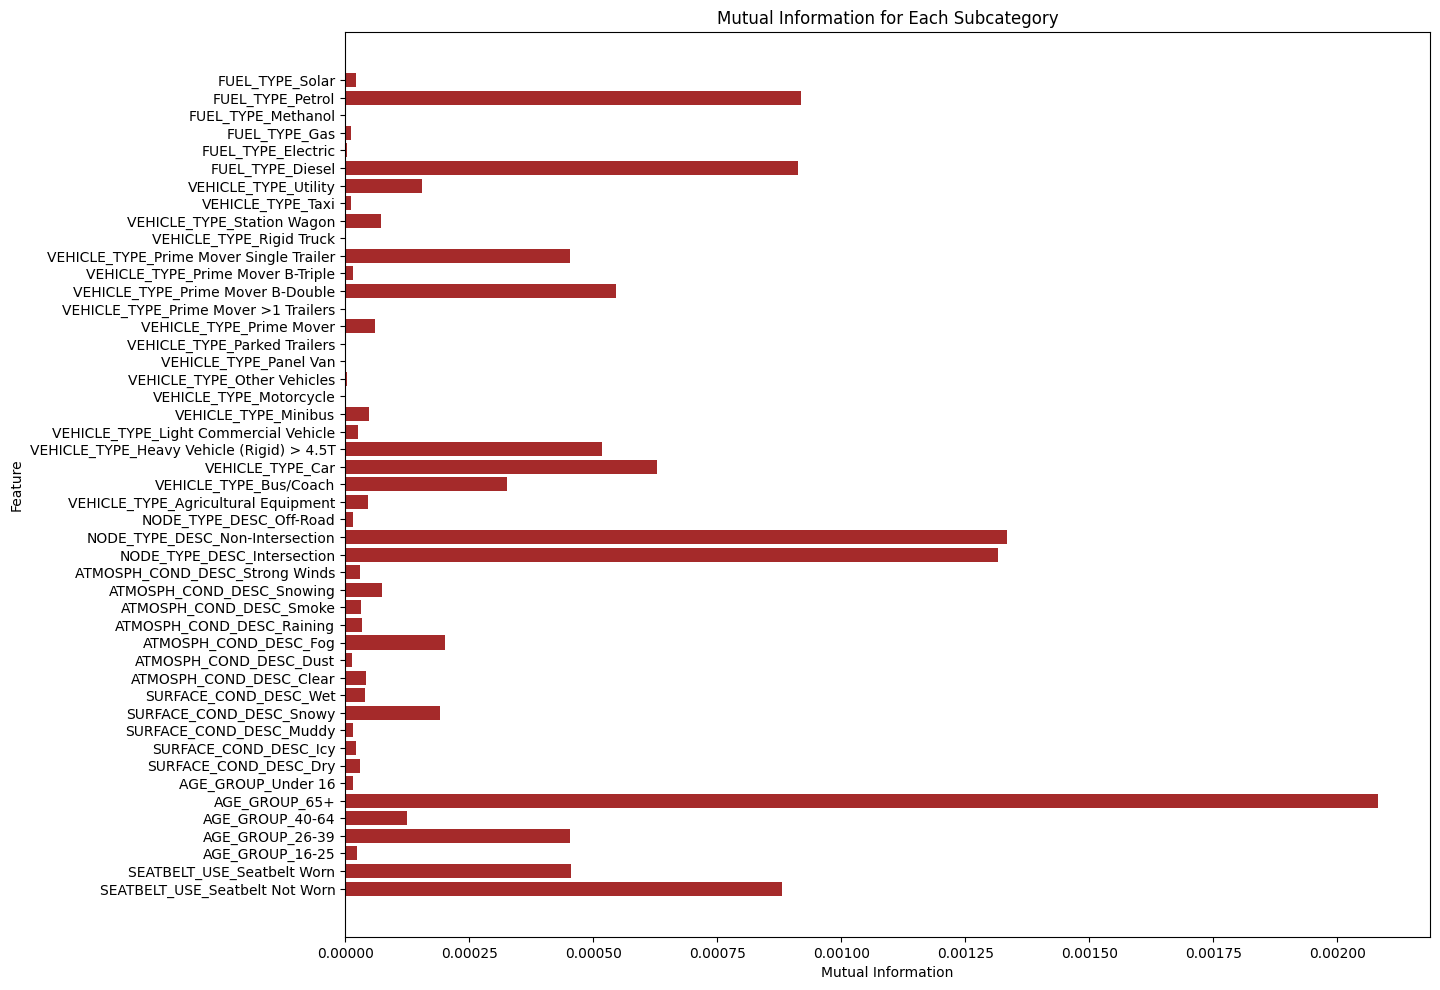

In [8]:
# Onehot encoding of all pre-processed features
encoded_df = pd.get_dummies(df, columns=['SEATBELT_USE', 'AGE_GROUP', 'SURFACE_COND_DESC', 'ATMOSPH_COND_DESC', 'NODE_TYPE_DESC', 'FUEL_TYPE', 'VEHICLE_TYPE'])

# subset the feature encoded columns from the merged df (features to predict accident severity)
seatbelt_cols = [col for col in encoded_df.columns if col.startswith('SEATBELT_USE_Seatbelt')]
age_cols = [col for col in encoded_df.columns if col.startswith('AGE_GROUP_')]
surface_cols = [col for col in encoded_df.columns if col.startswith('SURFACE_COND_DESC')]
atmosph_cols = [col for col in encoded_df.columns if col.startswith('ATMOSPH_COND_DESC')]
node_cols = [col for col in encoded_df.columns if col.startswith('NODE_TYPE_DESC')]
veh_type_cols = [col for col in encoded_df.columns if col.startswith('VEHICLE_TYPE')]
fuel_type_cols = [col for col in encoded_df.columns if col.startswith('FUEL_TYPE_')]

# features = veh_type_cols + fuel_type_cols + body_style_cols --> part of my initial code

target = 'SEVERITY' # target variable

features = seatbelt_cols + age_cols + surface_cols + atmosph_cols + node_cols + veh_type_cols + fuel_type_cols # concatenate all the feature cols into features list

# Find all the mutual information correlation between the features and the target
mi_arr = mutual_info_classif(X=encoded_df[features], y=encoded_df[target], discrete_features=True) # All features are discrete
# Store mutual information (value) and the subfeature (index) in a dictionary
MI_with_features = dict()
for feature, mi in zip(features, mi_arr):
    MI_with_features[feature] = mi # adding the mutual information to the dictionary

# A horizontal bar chart which displays the mutual information of each feature against each other
plt.figure(figsize=(14, len(MI_with_features) * 0.25))
plt.barh(MI_with_features.keys(), MI_with_features.values(), color = 'brown', capsize = 0.5)
plt.title("Mutual Information for Each Subcategory")
plt.xlabel("Mutual Information")
plt.ylabel("Feature")
plt.show()
features_selected = sorted(MI_with_features, key=lambda x: MI_with_features[x], reverse=True)[:3] # for feature selection, pick the features with the highest mutual information

Decision Tree Classification Report
              precision    recall  f1-score   support

           1      0.000     0.000     0.000      2539
           2      0.000     0.000     0.000     55824
           3      0.632     1.000     0.775    100360
           4      0.000     0.000     0.000         2

    accuracy                          0.632    158725
   macro avg      0.158     0.250     0.194    158725
weighted avg      0.400     0.632     0.490    158725



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


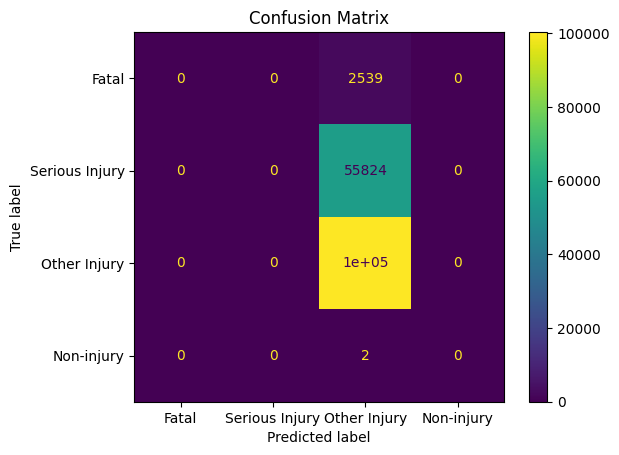

In [ ]:
# X represents features that will predict Y, the target/class label
X = encoded_df[features_selected]
y = encoded_df['SEVERITY']

# Split all the historical accident data into training and test data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42) # random state for reproducibility

# Run a decision tree model to classify accident severity based off the predictive features
dt = DecisionTreeClassifier(random_state=42, criterion='entropy')
dt.fit(X_train, y_train) # Fit the model to the training data
y_pred_dt = dt.predict(X_test) # Apply it to the test data

print("Decision Tree Classification Report")
print(classification_report(y_test, y_pred_dt, digits = 3)) # Print evaluation metrics for the model

# Display a confusion matrix to evaluate the decision tree model and its efficacy
cm = confusion_matrix(y_test, y_pred_dt, labels=[1, 2, 3, 4])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Fatal', 'Serious Injury', 'Other Injury', 'Non-injury'])
disp.plot()
plt.title("Confusion Matrix")
plt.show()

X_train, X_validate, y_train, y_validate = train_test_split(X_train, y_train, test_size = 0.2, random_state = 49)

X_train = X_train[features_selected] #Curse of Dimensionality
X_validate = X_validate[features_selected]

f1scores = list()

for i in range(2, 14):
  knn = KNeighborsClassifier(n_neighbors=i)
  knn.fit(X_train, y_train)

  # Note that we're calculating the accuracy score for the validating data
  y_pred = knn.predict(X_validate)

  accuracy = knn.score(X_validate, y_validate) # ratio of correctly predicted y-values based on x-values
  print('Accuracy', accuracy)

  print('Recall:', round(recall_score(y_validate, y_pred, average='weighted'),4))
  print('Precision:', round(precision_score(y_validate, y_pred, average='weighted'),4))
  f1score = round(f1_score(y_validate, y_pred,average='weighted'),4)
  f1scores.append(f1score)

In [ ]:
X_train = pd.concat([X_train, X_validate], axis=0)
y_train = pd.concat([y_train, y_validate], axis=0)

X_test = X_test[features_selected]

ideal_k_index = f1scores.index(max(f1scores))
ideal_k = ideal_k_index + 2 #loop starts from 2

knn = KNeighborsClassifier(n_neighbors=10)
knn.fit(X_train, y_train) # should add X_validate here

#Note that we're calculating the accuracy score for the validating data
y_pred = knn.predict(X_test)

accuracy = knn.score(X_test, y_test) # ratio of correctly predicted y-values based on x-values
print('Accuracy', accuracy)

cm = confusion_matrix(y_test, y_pred, labels=[1, 2, 3, 4])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Fatal', 'Serious Injury', 'Other Injury', 'Non-injury'])
disp.plot()
plt.title("Confusion Matrix")
plt.show()

print(classification_report(y_test, y_pred, digits = 3))